Importar dataframe que vamos a utilizar, en este caso el fichero housing.csv con datos publicados por la oficina del censo de EEUU en el que se recoge una muestra de 20640 distritos censales con datos referentes al alojamiento en cada uno de ellos.

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


housing = pd.read_csv("./housing.csv") 

housing


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


Realizamos una comprobación de los campos sin contenido que tenemos en el dataframe para analizar cual sería la mejor solución:

Dividimos el dataframe en predictores de entrenamiento y test, y en variable objetivo de entrenamiento y test con el metodo TrainTestSplit. Antes analizamos correlaciones entre predictores y variable objetivo

median_house_value    1.000000
median_income         0.688075
latitude             -0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude            -0.045967
population           -0.024650
Name: median_house_value, dtype: float64
count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64


<Axes: >

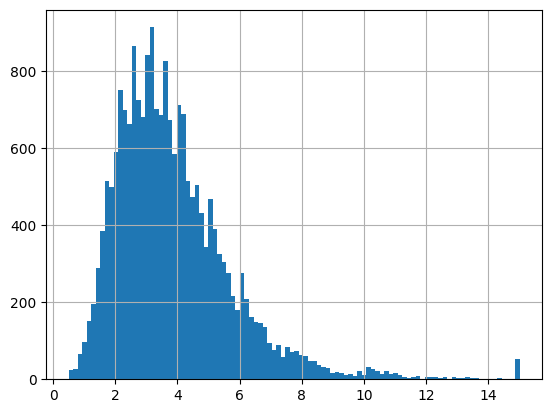

In [27]:
print (housing.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False, key=np.abs)) # Comprobar correlaciones
print (housing["median_income"].describe().T) #Comprobar valores maximos y minimos de "median_income"
housing["median_income"].hist(bins=100) # Imprimir histograma de "median_income" para relizar un estratificado en el reparto de datos de entrenamiento y test



In [28]:

housingX_train, housingX_test, housingY_train, housingY_test = train_test_split(
    housing.drop(columns="median_house_value"), # predictores
    housing["median_house_value"], # objetivo
    stratify=pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5]), #estratificar por predictor con buena correlacion con objetivo
    test_size=0.2, random_state=42
    )


housingX_train


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


Comprobamos que el dataset de predictores de entrenamiento tiene 16512 filas (el 80% del total tal como le pedimos al metodo), y 9 columnas ya que hemos separado la variable objetivo de los predictores. Podemos ver que el único predictor con campos vacantes es "total_bedrooms", y además la columna "ocean_proximity" contiene valores discretos que vamos a cambiar con el metodo "OneHotEncoder", lo que creará tantas columnas binarias como valores posibles hay en la columna.

In [29]:

null_rows_idx = housingX_train.isnull().any(axis=1) # índices de las filas con valores nulos
print (housingX_train.isna().sum())
housingX_train.loc[null_rows_idx].head(10).sort_index()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
4743,-118.36,34.05,42.0,1372.0,NaN,674.0,271.0,2.8793,<1H OCEAN
10236,-117.92,33.87,33.0,1597.0,NaN,1888.0,423.0,3.0550,<1H OCEAN
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
11512,-118.10,33.74,32.0,2035.0,NaN,934.0,512.0,4.2287,NEAR OCEAN
13069,-121.30,38.58,16.0,1537.0,NaN,1125.0,375.0,2.6471,INLAND
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
19607,-121.02,37.48,26.0,467.0,NaN,244.0,83.0,4.1346,INLAND


Utilizamos el método de scikit-learn "OneHotEncoder" que asigna un valor numérico asociado a un valor binario creado a partir del número de columnas en que se desdoblan las categorías existentes en el predictor.

In [30]:
from sklearn.preprocessing import OneHotEncoder


cat_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
hoXtrain_ohe = cat_encoder.fit_transform(housingX_train[["ocean_proximity"]])
hoXtrain_ohe


,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,0.0,1.0,0.0,0.0,0.0
15502,0.0,0.0,0.0,0.0,1.0
2908,0.0,1.0,0.0,0.0,0.0
14053,0.0,0.0,0.0,0.0,1.0
20496,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
15174,1.0,0.0,0.0,0.0,0.0
12661,0.0,1.0,0.0,0.0,0.0
19263,1.0,0.0,0.0,0.0,0.0
19140,1.0,0.0,0.0,0.0,0.0


Añadimos las nuevas columnas numericas y eliminamos la categórica de "OCEAN_PROXIMITY". Nos queda un dataframe con 16512 filas y 13 columnas predictoras para el grupo de entrenamiento. Ya todas son numéricas por lo que ya podemos escalar los valores.

In [31]:
hoXtrain_ohe2 = pd.concat([housingX_train.drop(columns="ocean_proximity"), hoXtrain_ohe], axis=1)
hoXtrain_ohe2

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,0.0,1.0,0.0,0.0,0.0
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,0.0,0.0,0.0,0.0,1.0
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,0.0,1.0,0.0,0.0,0.0
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,0.0,0.0,0.0,0.0,1.0
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,1.0,0.0,0.0,0.0,0.0
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,0.0,1.0,0.0,0.0,0.0
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,1.0,0.0,0.0,0.0,0.0
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,1.0,0.0,0.0,0.0,0.0


## Normalización de valores:

Para poder realizar el relleno de valores ausentes con el metodo de KNN_Imputer es conveniente previamente realizar una normalización de valores de modo que el escalado entre los distintos valores de los predictores sea próximo. 

In [35]:
hoXtrain_ohe2.describe().T


,count,mean,std,min,25%,50%,75%,max
longitude,16512.0,-119.575635,2.001828,-124.3500,-121.80000,-118.51000,-118.010000,-114.3100
latitude,16512.0,35.639314,2.137963,32.5400,33.94000,34.26000,37.720000,41.9500
housing_median_age,16512.0,28.653404,12.574819,1.0000,18.00000,29.00000,37.000000,52.0000
total_rooms,16512.0,2622.539789,2138.417080,6.0000,1443.00000,2119.00000,3141.000000,39320.0000
total_bedrooms,16354.0,534.914639,412.665649,2.0000,295.00000,433.00000,644.000000,6210.0000
population,16512.0,1419.687379,1115.663036,3.0000,784.00000,1164.00000,1719.000000,35682.0000
households,16512.0,497.011810,375.696156,2.0000,279.00000,408.00000,602.000000,5358.0000
median_income,16512.0,3.875884,1.904931,0.4999,2.56695,3.54155,4.745325,15.0001
ocean_proximity_<1H OCEAN,16512.0,0.440710,0.496487,0.0000,0.00000,0.00000,1.000000,1.0000
ocean_proximity_INLAND,16512.0,0.318677,0.465978,0.0000,0.00000,0.00000,1.000000,1.0000


Utilizamos el método "StandardScaler" de scikit-learn.

In [8]:

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler().set_output(transform="pandas") #configuramos el escalador para que la salida sea un df de pandas
#print (type(hoXtrain_ohe2))
hoXtrain_ohe2_scal = std_scaler.fit_transform(hoXtrain_ohe2)
#print (type(hoXtrain_ohe2_scal))
#hoXtrain_ohe2_scal.head(5)
#print (hoXtrain_ohe2_scal.sort_index())
hoXtrain_ohe2_scal

#hoXtrain_ohe2_scal.describe().T

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.635123,0.732602,0.556286,-0.893647,-0.887683,1.46218,-0.011006,-0.354889,-0.384217
15502,1.171782,-1.192440,-1.722018,1.261467,0.775677,0.533612,0.721318,1.292168,-0.887683,-0.68391,-0.011006,-0.354889,2.602693
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545045,-0.674675,-0.524407,-0.525434,-0.887683,1.46218,-0.011006,-0.354889,-0.384217
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.038567,-0.467617,-0.037297,-0.865929,-0.887683,-0.68391,-0.011006,-0.354889,2.602693
20496,0.437431,-0.635818,-0.131489,0.427179,0.269198,0.374060,0.220898,0.325752,1.126529,-0.68391,-0.011006,-0.354889,-0.384217
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.686854,0.543471,1.341519,0.637374,1.126529,-0.68391,-0.011006,-0.354889,-0.384217
12661,-0.921368,1.342761,-1.085806,2.468471,2.149712,3.002174,2.451492,-0.557509,-0.887683,1.46218,-0.011006,-0.354889,-0.384217
19263,-1.570794,1.310018,1.538566,-0.895802,-0.894007,-0.862013,-0.865118,-0.365475,1.126529,-0.68391,-0.011006,-0.354889,-0.384217
19140,-1.560803,1.249211,-1.165333,0.249005,0.109257,-0.189747,0.010616,0.168261,1.126529,-0.68391,-0.011006,-0.354889,-0.384217


comprobamos que hay un valor máximo que se sale de escala mucho, investigamos a ver si sacamos alguna conclusión.

In [9]:
print (hoXtrain_ohe2_scal["ocean_proximity_ISLAND"].sort_values())
print (hoXtrain_ohe2["ocean_proximity_ISLAND"].sort_values())
       
hoXtrain_ohe2_scal["ocean_proximity_ISLAND"].describe().T


12655    -0.011006
17278    -0.011006
13113    -0.011006
19216    -0.011006
15858    -0.011006
           ...    
6037     -0.011006
11520    -0.011006
19773    -0.011006
8318     90.857031
8315     90.857031
Name: ocean_proximity_ISLAND, Length: 16512, dtype: float64
12655    0.0
17278    0.0
13113    0.0
19216    0.0
15858    0.0
        ... 
6037     0.0
11520    0.0
19773    0.0
8318     1.0
8315     1.0
Name: ocean_proximity_ISLAND, Length: 16512, dtype: float64


count    1.651200e+04
mean    -3.429105e-18
std      1.000030e+00
min     -1.100630e-02
25%     -1.100630e-02
50%     -1.100630e-02
75%     -1.100630e-02
max      9.085703e+01
Name: ocean_proximity_ISLAND, dtype: float64

Observamos que se trata de los unicos valores a 1 de la columna "ocean_proximity_ISLAND". Al tratarse de solo 2 valores True en una serie de mas de 16000 valores, entendemos que al escalar le otorga un valor alto respecto a los demás ya que con diferencia es el más atípico. Damos por bueno el escalado.

#### Como prueba vamos a realizar una inversion del escalado con el método Inverse_transform de la clase StandardScaler. Devuelve los valores a su escala original, por lo que continuamos con el dataframe transformado y escalado para realizar la imputacion.

In [10]:
# Prueba de inversión de escalado, comprobamos que los valores vuelven a estar en su escala original


hoXtrain_ohe2_invtransform = pd.DataFrame(std_scaler.inverse_transform(hoXtrain_ohe2_scal), columns=hoXtrain_ohe2_scal.columns) 


print (type(hoXtrain_ohe2_invtransform))
hoXtrain_ohe2_invtransform.sort_index()






<class 'pandas.core.frame.DataFrame'>


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,0.0,1.0,-1.355253e-20,0.0,0.0
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,0.0,0.0,-1.355253e-20,0.0,1.0
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,0.0,1.0,-1.355253e-20,0.0,0.0
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,0.0,0.0,-1.355253e-20,0.0,1.0
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,1.0,0.0,-1.355253e-20,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,1.0,0.0,-1.355253e-20,0.0,0.0
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,0.0,1.0,-1.355253e-20,0.0,0.0
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,1.0,0.0,-1.355253e-20,0.0,0.0
16510,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,1.0,0.0,-1.355253e-20,0.0,0.0


Comprobamos que continuamos teniendo los missing values, pero con los datos ya preprocesados para aplicar el KNNImputer

In [11]:
hoXtrain_ohe2_scal.isna().sum()

longitude                       0
latitude                        0
housing_median_age              0
total_rooms                     0
total_bedrooms                158
population                      0
households                      0
median_income                   0
ocean_proximity_<1H OCEAN       0
ocean_proximity_INLAND          0
ocean_proximity_ISLAND          0
ocean_proximity_NEAR BAY        0
ocean_proximity_NEAR OCEAN      0
dtype: int64

Aplicamos KNNImputer para rellenar los Nan en el predictor Total Bedrooms, vamos a utilizar como valor de k n_vecinos el estándar de la raiz del numero de instancias

In [12]:


from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=np.sqrt(housingX_train.shape[0]).astype(int))
hoXtrain_ohe2_scal_imputed=pd.DataFrame(imputer.fit_transform(hoXtrain_ohe2_scal), columns=hoXtrain_ohe2_scal.columns, index=hoXtrain_ohe2_scal.index)
print (hoXtrain_ohe2_scal_imputed.isna().sum())
hoXtrain_ohe2_scal_imputed





longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
ocean_proximity_<1H OCEAN     0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.635123,0.732602,0.556286,-0.893647,-0.887683,1.46218,-0.011006,-0.354889,-0.384217
15502,1.171782,-1.192440,-1.722018,1.261467,0.775677,0.533612,0.721318,1.292168,-0.887683,-0.68391,-0.011006,-0.354889,2.602693
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545045,-0.674675,-0.524407,-0.525434,-0.887683,1.46218,-0.011006,-0.354889,-0.384217
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.038567,-0.467617,-0.037297,-0.865929,-0.887683,-0.68391,-0.011006,-0.354889,2.602693
20496,0.437431,-0.635818,-0.131489,0.427179,0.269198,0.374060,0.220898,0.325752,1.126529,-0.68391,-0.011006,-0.354889,-0.384217
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.686854,0.543471,1.341519,0.637374,1.126529,-0.68391,-0.011006,-0.354889,-0.384217
12661,-0.921368,1.342761,-1.085806,2.468471,2.149712,3.002174,2.451492,-0.557509,-0.887683,1.46218,-0.011006,-0.354889,-0.384217
19263,-1.570794,1.310018,1.538566,-0.895802,-0.894007,-0.862013,-0.865118,-0.365475,1.126529,-0.68391,-0.011006,-0.354889,-0.384217
19140,-1.560803,1.249211,-1.165333,0.249005,0.109257,-0.189747,0.010616,0.168261,1.126529,-0.68391,-0.011006,-0.354889,-0.384217


#### Comprobamos que se han rellenado los valores que estaban vacantes.

In [13]:
housingX_train.describe()
hoXtrain_ohe2_scal_imputed.describe()


print (housingX_train[null_rows_idx].T)
print (hoXtrain_ohe2_scal_imputed.loc[null_rows_idx].T)

                       1606       10915      19150      4186        16885  \
longitude            -122.08    -117.87     -122.7    -118.23      -122.4   
latitude               37.88      33.73      38.35      34.13       37.58   
housing_median_age      26.0       45.0       14.0       48.0        26.0   
total_rooms           2947.0     2264.0     2313.0     1308.0      3281.0   
total_bedrooms           NaN        NaN        NaN        NaN         NaN   
population             825.0     1970.0      954.0      835.0      1145.0   
households             626.0      499.0      397.0      294.0       480.0   
median_income          2.933     3.4193     3.7813     4.2891       6.358   
ocean_proximity     NEAR BAY  <1H OCEAN  <1H OCEAN  <1H OCEAN  NEAR OCEAN   

                         11512   13069      4743    19607      10236  ...  \
longitude               -118.1  -121.3    -118.36 -121.02    -117.92  ...   
latitude                 33.74   38.58      34.05   37.48      33.87  ...  

## Creando un pipeline

In [44]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline




# Definir las columnas categóricas y numéricas
categorical_cols = ['ocean_proximity']
numeric_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

# Construir el preprocesador combinando columnas categóricas y numéricas
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_cols),
])

# Pipeline final con todos los pasos, incluyendo la imputación
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', std_scaler(preprocessor)   )
    ('imputer', KNNImputer(n_neighbors=int(np.sqrt(housingX_train.shape[0]))))
])

# Aplicar el pipeline al conjunto de entrenamiento
hoXtrain_preprocessed = pipeline.fit_transform(housingX_train)

# Convertir el resultado a DataFrame
hoXtrain_preprocessed = pd.DataFrame(
    hoXtrain_preprocessed,
    columns = list(preprocessor.transformers_[0][1].get_feature_names_out()) + numeric_cols,
    index = housingX_train.index
)













<>:21: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:21: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\a_sal\AppData\Local\Temp\ipykernel_48452\267190795.py:21: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('scaler', std_scaler(preprocessor)   )


TypeError: 'StandardScaler' object is not callable

In [ ]:
hoXtrain_ohe2_scal_imputed.sort_index().T

,0,1,2,3,4,5,6,7,8,9,...,20628,20629,20630,20632,20633,20634,20635,20636,20637,20638
longitude,-1.326011,-1.321015,-1.331006,-1.336002,-1.336002,-1.336002,-1.336002,-1.336002,-1.340997,-1.336002,...,-0.951342,-0.906381,-0.871412,-0.936355,-0.976320,-0.991306,-0.756514,-0.816461,-0.821456,-0.871412
latitude,1.048079,1.038724,1.034046,1.034046,1.034046,1.034046,1.029369,1.029369,1.029369,1.029369,...,1.618733,1.628088,1.707605,1.693573,1.660830,1.698250,1.796477,1.801155,1.773090,1.773090
housing_median_age,0.981881,-0.608648,1.856671,1.856671,1.856671,1.856671,1.856671,1.856671,1.061407,1.856671,...,-0.767701,-0.051963,-1.403912,-1.085806,-0.131489,-0.051963,-0.290542,-0.847227,-0.926753,-0.847227
total_rooms,-0.814898,2.093416,-0.540388,-0.630644,-0.465564,-0.796660,-0.040938,0.225155,-0.031585,0.433259,...,-0.271022,3.466435,0.008165,-0.141950,-0.253719,-0.135871,-0.447793,-0.900478,-0.172348,-0.356602
total_bedrooms,-0.983671,1.383936,-0.835847,-0.726796,-0.617746,-0.780110,-0.111267,0.368555,0.315242,0.417022,...,-0.276054,3.201443,-0.072493,-0.288171,-0.297864,-0.339061,-0.389951,-0.932780,-0.120960,-0.305134
population,-0.983918,0.879605,-0.827952,-0.772378,-0.766103,-0.902349,-0.291932,-0.235461,-0.191540,0.117703,...,-0.360055,4.923063,-0.145826,-0.334060,-0.302688,-0.339438,-0.515124,-0.953442,-0.369914,-0.608345
households,-0.987561,1.706186,-0.851809,-0.740014,-0.633541,-0.809220,0.045219,0.399239,0.260826,0.577580,...,-0.284845,3.516214,-0.138445,-0.298154,-0.306139,-0.407288,-0.444553,-1.019503,-0.170387,-0.393979
median_income,2.335755,2.323260,1.775192,0.927734,-0.015583,0.084476,-0.113805,-0.396816,-0.942574,-0.096954,...,-0.672320,-0.935277,-0.161997,-0.394191,-0.696311,-0.085772,-1.215611,-0.692479,-1.142273,-1.054498
ocean_proximity_<1H OCEAN,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,...,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683,-0.887683
ocean_proximity_INLAND,-0.683910,-0.683910,-0.683910,-0.683910,-0.683910,-0.683910,-0.683910,-0.683910,-0.683910,-0.683910,...,1.462180,1.462180,1.462180,1.462180,1.462180,1.462180,1.462180,1.462180,1.462180,1.462180


## Comprobación de la solución

Podemos también convertir de nuevo a DataFrame y comparar los resultados procesados por los dos métodos.

In [ ]:


print("¿Hay valores nulos?", hoXtrain_ohe2_scal_imputed_2.isna().any().any()) # Verificamos que no hay valores nulos

# Comprobamos que housingX_train_imputed_a y hoXtrain_ohe2_scal_imputed_2 son iguales
print("¿Son los resultados iguales paso a paso y con el pipeline?",(hoXtrain_ohe2_scal_imputed.values==hoXtrain_ohe2_scal_imputed_2.values).all())

ValueError: Shape of passed values is (16512, 25241), indices imply (16512, 13)